# <center> Proyecto Chicago - Madres Solteras

In [52]:
# LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import plotly.express as px

from sklearn.model_selection import train_test_split                              # Para partir la data en X_train, y_train, X_test, y_test

from sklearn.preprocessing import StandardScaler                                  # Escalar los datos
scaler = StandardScaler()

# Metricas de ajuste 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Randomforest
from sklearn.ensemble import RandomForestClassifier

# Red Neuronal
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

# Graficos
import networkx as nx
import matplotlib.pyplot as plt


In [68]:
### FUNCIONES AUXILIARES

def Graph(X, Y):
    '''
    ESTA FUNCION RETORNARA LA GRAFICA PARA LA VARIABLE INGRESADA
    X: ES LA VARIABLE DEL DATAFRAME
    Y: ES EL TEXTO QUE SE QUIERE QUE APARESCA POR EL DE LA VARIABLE
    '''
    B = data.copy()
    B['aux'] = B['Felicidad'].copy()
    B = B.groupby(X).agg('count').reset_index()
    B = B[[X, 'aux']]
    B = B.rename(columns={'aux': 'Count'})
    B = B.sort_values('Count', ascending = False)
    '''
    EN EL SIGUIENTE GRAFICO SE MUESTRAN EL CONTEO TOTAL POR VARIABLE
    '''
    fig = px.bar(B, x = X, y = 'Count',
                 title = "Conteo por " + Y,
                 template = "plotly_dark",
                 labels = {X: Y, "count": "Conteo"})
    return fig.show()


def Mayoria(X, Z):
    '''
    ESTA FUNCION RETORNARA EL PORCENTAJE A LA QUE CORRESPONDE LA MAYOR CLASE DE LA VARIABLE
    X: VARIABLE DEL DATAFRAME
    Z: CLASE CON LA QUE SE QUIERE COMPARAR
    '''
    H = data.copy()
    H['que'] = np.where((H[X] == Z), 1, 0)
    # Revisar cuantos 1 contiene la variable que
    P = H.que.sum() / H.que.count()
    print(Z, 'corresponde al ', P, ' porcentaje de la variable: ', X)
    
    
def createDummies(df, lista_var_name):
    '''
    INGRESE EL DF Y UN LISTADO DE LAS VARIABLES QUE SE LES QUIERE GENERAR LOS DUMMIES, ELIMINA UNA DE ELLAS Y ELIMINA 
    LA VARIABLE ORIGINAL, CONCATENA CON EL DATA ORIGINAL Y LO RETORNA
    '''
    for i in lista_var_name:
        dummy = pd.get_dummies(df[i], drop_first = True, prefix = i)
        df = df.drop(i, axis = 1)
        df = pd.concat([df, dummy], axis = 1)
    return df
    
    
def evaluate_model(y_test, y_pred, model = None):
    """
    Aqui se pondran las cuatro metricas que se piden en el reporte
    debido a que cada modelo requiere las mismas metricas es probable que se pueda ejecutar el mismo para todas
    """
    f1 = print('El f1 score es de: ', f1_score(y_test, y_pred, average = 'weighted'))
    acc = print('El acc score es de: ', accuracy_score(y_test, y_pred))
    ps = print('La precision es de: ', precision_score(y_test, y_pred, average = 'micro'))
    re = print('El f1 score es de: ', recall_score(y_test, y_pred, average = 'micro'))
    
    return f1, acc, ps, re



def matconfision(y_test, y_pred):
    '''EN ESTA FUNCION ENTRAN LAS Y ORIGINALES Y LAS PREDICCIONES PARA CREAR UNA MATRIZ DE CONFUSION MAS BONITA'''
    
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    target_names = set(y)
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    
    return plt.show(block=False)

## Tabla Datos de la vivienda

In [15]:
df = pd.read_csv('Datos de la vivienda.csv', sep = ';', header = 0)

In [16]:
df = df.rename(columns={'P8520S1':'Energia', 'P1070': 'Tipo_de_vivienda', 'P8520S5': 'Acueducto', 
                        'P8520S3': 'Alcantarillado', 'P8520S4': 'Recoleccion_Basura','P5661S3': 'Basura', 
                        'P5661S4': 'Aire', 'P5661S5': 'Invaciones', 'P5661S9': 'Contaminacion_Rios'})

In [17]:
df.drop(['FEX_C', 'DPTO', 'SECUENCIA_P', 'CANT_HOG_COMPLETOS', 'P4005', 'P4015', 'P4567', 'P8520', 'P8520S1A1', 
         'P8520S4A1', 'P4065S1', 'P4065S2', 'P4065S3', 'P4065S4', 'P5661', 'P5661S1', 'P5661S6', 'P5661S7', 'P5661S2',
         'P4065'], 
        axis=1, inplace=True)

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DIRECTORIO,88713.0,7.058032e+06,33137.326463,7000000.0,7028501.0,7059225.0,7086550.0,7119774.0
SECUENCIA_ENCUESTA,88713.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
ORDEN,88713.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
REGION,88713.0,3.894649e+00,2.850847,1.0,2.0,3.0,6.0,9.0
CANT_HOGARES_VIVIENDA,88713.0,1.009119e+00,0.113838,1.0,1.0,1.0,1.0,8.0
CLASE,88713.0,1.454218e+00,0.497902,1.0,1.0,1.0,2.0,2.0
Tipo_de_vivienda,88713.0,1.308162e+00,0.610201,1.0,1.0,1.0,1.0,5.0
Energia,88713.0,1.064083e+00,0.244902,1.0,1.0,1.0,1.0,2.0
Acueducto,88713.0,1.284648e+00,0.451249,1.0,1.0,1.0,2.0,2.0
Alcantarillado,88713.0,1.488080e+00,0.499861,1.0,1.0,1.0,2.0,2.0


In [19]:
# Guardar data
df.to_csv('data_general.csv', index = False, encoding = "UTF-8")

In [20]:
df.shape

(88713, 15)

## Tabla Servicios del hogar

In [21]:
df2 = pd.read_csv('Servicios del hogar.csv', sep = ';', header = 0)
df2.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,FEX_C,P5000,P5010,P5016,P5016S5,P5016S6,...,P8534,P8536,P1698,P1698S1,P5305,I_HOGAR,I_UGASTO,PERCAPITA,I_OU,CANT_PERSONAS_HOGAR
0,7000000,1,1,1,"384,328169349074",4,2,,,1,...,,2,2,,1,2300000,2300000,1150000,0,2
1,7000001,1,1,1,"297,172456158384",4,2,,,,...,,2,2,,1,3825000,3825000,1275000,0,3
2,7000002,1,1,1,"274,640130499086",3,2,,,,...,,2,2,,1,"2386666,66666667","966666,666666667","483333,333333333",1420000,3
3,7000003,1,1,1,"125,253015015194",4,2,,,,...,,2,2,,2,"1983333,33333333","1983333,33333333","991666,666666667",0,2
4,7000004,1,1,1,"195,420015121655",3,1,,,,...,,2,2,,2,2080000,2080000,2080000,0,1


In [23]:
df2 = df2.rename(columns={'P5000':'Num_Cuartos', 'P5010': 'Num_duermen'})

In [24]:
df2 = df2.loc[:, ['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'ORDEN', 'Num_Cuartos', 'Num_duermen', 'I_HOGAR', 
                  'CANT_PERSONAS_HOGAR']]

In [25]:
df2.drop(df2[df2['Num_Cuartos'] == 99].index, inplace = True)
df2.drop(df2[df2['Num_duermen'] == 99].index, inplace = True)

In [26]:
df2.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,ORDEN,Num_Cuartos,Num_duermen,I_HOGAR,CANT_PERSONAS_HOGAR
0,7000000,1,1,4,2,2300000,2
1,7000001,1,1,4,2,3825000,3
2,7000002,1,1,3,2,"2386666,66666667",3
3,7000003,1,1,4,2,"1983333,33333333",2
4,7000004,1,1,3,1,2080000,1


In [27]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
DIRECTORIO,89500.0,7.057974e+06,33177.522778,7000000.0,7028395.75,7059160.5,7086541.25,7119774.0
SECUENCIA_ENCUESTA,89500.0,1.010983e+00,0.127556,1.0,1.00,1.0,1.00,8.0
ORDEN,89500.0,1.010983e+00,0.127556,1.0,1.00,1.0,1.00,8.0
Num_Cuartos,89500.0,3.146279e+00,1.199685,1.0,2.00,3.0,4.00,23.0
Num_duermen,89500.0,1.853721e+00,0.864234,1.0,1.00,2.0,2.00,17.0
CANT_PERSONAS_HOGAR,89500.0,3.161229e+00,1.721940,1.0,2.00,3.0,4.00,20.0


In [28]:
auxiliar_tabla = pd.merge(df, df2, on = ['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'ORDEN'])
auxiliar_tabla.tail()

,DIRECTORIO,SECUENCIA_ENCUESTA,ORDEN,REGION,CANT_HOGARES_VIVIENDA,CLASE,Tipo_de_vivienda,Energia,Acueducto,Alcantarillado,Recoleccion_Basura,Basura,Aire,Contaminacion_Rios,Invaciones,Num_Cuartos,Num_duermen,I_HOGAR,CANT_PERSONAS_HOGAR
88686,7119770,1,1,2,1,2,1,1,1,2,1,1,1,1,1,3,1,320000,2
88687,7119771,1,1,2,1,2,1,1,2,2,2,1,1,1,1,3,2,"756666,666666667",4
88688,7119772,1,1,2,1,2,1,1,1,2,2,1,1,1,1,2,2,562500,2
88689,7119773,1,1,3,1,2,1,2,2,2,2,1,1,1,1,4,3,1100000,4
88690,7119774,1,1,3,1,1,1,2,2,1,1,2,1,2,1,2,2,290000,3


In [29]:
# Guardar data
auxiliar_tabla.to_csv('data_general.csv', index = False, encoding = "UTF-8")

## Tabla Caracteristicas y composicion del hogar

In [30]:
df3 = pd.read_csv('Caracteristicas y composicion del hogar.csv', sep = ';', header = 0)
df3.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,FEX_C,P6016,P1894,P6020,P6034,P6040,...,P1895,P1896,P1897,P1898,P1899,P1901,P1903,P1904,P1905,P1927
0,7000000,1,1,1,"384,328169349074",1,3,2,1,64,...,10,4,0,4,8,8,2,4,8,9
1,7000000,2,1,2,"384,328169349074",2,3,1,1,26,...,8,8,10,7,8,10,6,1,8,8
2,7000001,1,1,1,"297,172456158384",1,3,1,1,56,...,9,9,7,8,9,9,1,1,9,9
3,7000001,2,1,2,"297,172456158384",2,3,2,1,54,...,8,9,8,7,9,9,2,1,9,9
4,7000001,3,1,3,"297,172456158384",1,2,2,1,14,...,,,,,,,,,,


In [31]:
df3 = df3.rename(columns={'P1894':'ID', 'P6020':'Sexo', 'P6051':'Parentesco', 'P6040':'Edad', 'P5502':'Estado_civil',
                          'P6096': 'Razon_desplazamiento', 'P6081': 'Padre_vive', 'P6083': 'Madre_vive', 
                          'P1895': 'Satisfaccion_vida', 'P1896': 'Satisfaccion_economica', 'P1897': 'Satisfaccion_salud', 
                          'P1898': 'Satisfaccion_seguridad', 'P1899': 'Satisfaccion_trabajo', 'P1901': 'Felicidad',
                          'P1903': 'Preocupacion', 'P1904': 'Tristeza', 'P1905': 'Deseo_vivir', 'P1927': 'Escalon_vida'})

In [32]:
df3.drop(['FEX_C', 'SECUENCIA_P', 'P6034', 'P6071S1', 'P756', 'P756S2', 'P767', 'P6076', 'P6076S1', 'P6076S2', 'P6077', 
          'P6081S1', 'P6087', 'P6083S1', 'P6088', 'P6080', 'P5667', 'P6016', 'P756S1', 'P6071', 'P6074'], axis=1, inplace=True)

In [33]:
df3 = df3[(df3['Sexo'] == 2) & (df3['Parentesco'] == 1)]
df3.drop(['Sexo', 'Parentesco'], axis = 1, inplace = True)

In [34]:
lit = list(['3', '4', '5'])
df3 = df3.loc[df3['Estado_civil'].isin(lit)]
df3.drop(['Estado_civil'], axis = 1, inplace = True)
df3['Razon_desplazamiento'] = np.where((df3['Razon_desplazamiento'] == ' '), '0', df3['Razon_desplazamiento'])
df3.drop(df3[df3['Felicidad'] == ' '].index, inplace = True)
df3.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,ORDEN,ID,Edad,Razon_desplazamiento,Padre_vive,Madre_vive,Satisfaccion_vida,Satisfaccion_economica,Satisfaccion_salud,Satisfaccion_seguridad,Satisfaccion_trabajo,Felicidad,Preocupacion,Tristeza,Deseo_vivir,Escalon_vida
0,7000000,1,1,3,64,0,3,3,10,4,0,4,8,8,2,4,8,9
8,7000003,1,1,3,61,0,3,3,8,8,10,4,7,9,0,3,8,8
25,7000011,1,1,3,27,0,2,2,9,7,9,10,5,10,6,8,10,9
43,7000017,1,1,3,74,0,3,3,6,9,9,8,8,6,6,8,9,10
59,7000024,1,1,3,78,8,3,3,8,3,8,8,10,9,3,2,10,8


In [35]:
df3.shape

(21786, 18)

In [36]:
auxiliar_tabla = pd.merge(auxiliar_tabla, df3, on = ['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'ORDEN'])
auxiliar_tabla.tail()

,DIRECTORIO,SECUENCIA_ENCUESTA,ORDEN,REGION,CANT_HOGARES_VIVIENDA,CLASE,Tipo_de_vivienda,Energia,Acueducto,Alcantarillado,...,Satisfaccion_vida,Satisfaccion_economica,Satisfaccion_salud,Satisfaccion_seguridad,Satisfaccion_trabajo,Felicidad,Preocupacion,Tristeza,Deseo_vivir,Escalon_vida
21779,7119456,1,1,9,1,2,1,1,2,2,...,10,99,10,10,5,10,4,0,10,10
21780,7119467,1,1,9,1,1,1,1,1,1,...,8,7,10,7,7,8,3,0,8,8
21781,7119511,1,1,5,1,1,1,1,1,1,...,8,6,9,8,7,8,5,5,8,5
21782,7119515,1,1,5,1,1,1,1,1,1,...,9,8,8,7,8,8,3,0,8,8
21783,7119630,1,1,9,1,2,1,1,1,2,...,6,4,9,8,4,8,5,6,5,8


In [37]:
auxiliar_tabla.shape

(21784, 34)

In [38]:
# Guardar data
auxiliar_tabla.to_csv('data_general.csv', index = False, encoding = "UTF-8")

# Correccion de la variable I_HOGAR

In [39]:
data = pd.read_csv('data_general.csv', sep = ',', header = 0)
data.head()

listica = data['I_HOGAR']
listica2 = []

for i in listica:
    matchList = re.findall(r',', i)
    longitud = len(matchList)
    
    if longitud > 0:
        match = re.match(r"(\d+),(\d+)", i)
        listica2.append(match.groups()[0])
    
    else:
        listica2.append(i)
    
data['Ingreso_Hogares'] = listica2
data.drop(['I_HOGAR'], axis=1, inplace=True)
data.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,ORDEN,REGION,CANT_HOGARES_VIVIENDA,CLASE,Tipo_de_vivienda,Energia,Acueducto,Alcantarillado,...,Satisfaccion_economica,Satisfaccion_salud,Satisfaccion_seguridad,Satisfaccion_trabajo,Felicidad,Preocupacion,Tristeza,Deseo_vivir,Escalon_vida,Ingreso_Hogares
0,7000000,1,1,1,1,1,1,1,1,1,...,4,0,4,8,8,2,4,8,9,2300000
1,7000003,1,1,2,1,1,1,1,1,1,...,8,10,4,7,9,0,3,8,8,1983333
2,7000011,1,1,9,1,1,1,1,1,1,...,7,9,10,5,10,6,8,10,9,971250
3,7000017,1,1,1,1,1,1,1,1,1,...,9,9,8,8,6,6,8,9,10,2100000
4,7000024,1,1,3,1,1,1,1,1,1,...,3,8,8,10,9,3,2,10,8,1546345


In [40]:
# Guardar data
data.to_csv('data_general.csv', index = False, encoding = "UTF-8")

# <center> Modelo
    
**ORDENAR DATA**

In [159]:
data = pd.read_csv('data_general.csv', sep = ',', header = 0)
data.drop(['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'ORDEN'], axis = 1, inplace = True)
#data.drop(data[data['Satisfaccion_economica'] > 10].index, inplace = True)
data.drop(data[data['Ingreso_Hogares'] > 5000000].index, inplace = True)
data.to_csv('data_general2.csv', index = False, encoding = "UTF-8")
data.shape

(3973, 31)

In [160]:
data = pd.read_csv('data_general2.csv', sep = ',', header = 0)
data.head()

,REGION,CANT_HOGARES_VIVIENDA,CLASE,Tipo_de_vivienda,Energia,Acueducto,Alcantarillado,Recoleccion_Basura,Basura,Aire,...,Satisfaccion_economica,Satisfaccion_salud,Satisfaccion_seguridad,Satisfaccion_trabajo,Felicidad,Preocupacion,Tristeza,Deseo_vivir,Escalon_vida,Ingreso_Hogares
0,1,1,1,1,1,1,1,1,1,1,...,9,9,8,8,6,6,8,9,10,2100000
1,9,1,1,1,1,1,1,1,2,1,...,5,5,5,4,6,6,5,6,6,430416
2,9,1,1,1,1,2,2,1,1,2,...,3,5,5,3,5,3,2,5,5,225000
3,4,1,1,1,1,1,1,1,1,1,...,7,5,7,6,5,3,1,8,7,2551000
4,4,1,1,2,1,1,1,1,1,1,...,3,6,4,3,4,7,5,8,7,901000


In [158]:
#Graph("REGION", "Region")
#Graph("CANT_HOGARES_VIVIENDA", "Cantidad de Hogares en una Vivienda")*
#Graph("CLASE", "Clase")
#Graph("Tipo_de_vivienda", "Tipo de Vivienda")
#Graph("Energia", "Energia")*
#Graph("Acueducto", "Acueducto")
#Graph("Alcantarillado", "Alcantarillado")
#Graph("Recoleccion_Basura", "Recoleccion Basura")
#Graph("Basura", "Basura")
#Graph("Aire", "Aire")
#Graph("Contaminacion_Rios", "Contaminacion Rios")
#Graph("Invaciones", "Invaciones")
#Graph("Num_Cuartos", "Numeros de Cuartos")
#Graph("Aire", "Aire")
#Graph("Contaminacion_Rios", "Contaminacion Rios")
#Graph("Invaciones", "Invaciones")
#Graph("Num_Cuartos", "Numero de Cuartos en casa")
#Graph("Num_duermen", "Numero de personas que duermen en casa")
#Graph("CANT_PERSONAS_HOGAR", "Cantidad de Personas en el Hogar")
#Graph("ID", "Identificacion")
#Graph("Edad", "Edad")
#Graph("Razon_desplazamiento", "Razon del Desplazamiento")
#Graph("Padre_vive", "Padre de la mujer vive en casa")
#Graph("Madre_vive", "Madre de la mujer vive en casa")
#Graph("Satisfaccion_vida", "Puntaje asigado a la pregunta Satisfaccion vida")
#Graph("Satisfaccion_economica", "Puntaje asigado a la pregunta Satisfaccion economica")
#Graph("Satisfaccion_salud", "Puntaje asigado a la pregunta Satisfaccion salud")
#Graph("Satisfaccion_seguridad", "Puntaje asigado a la pregunta Satisfaccion seguridad")
#Graph("Satisfaccion_trabajo", "Puntaje asigado a la pregunta Satisfaccion trabajo")
#Graph("Preocupacion", "Puntaje asigado a la pregunta Preocupacion de Ayer")
#Graph("Tristeza", "Puntaje asigado a la pregunta Tristeza de Ayer")
#Graph("Deseo_vivir", "Deseo de Vivir")
#Graph("Escalon_vida", "Momento (etapa) en la que se encuentra en la vida")
#fig = px.histogram(data, x = "Ingreso_Hogares", 
#                   template = "plotly_dark",
#                   labels = {"Ingreso_Hogares": 'Ingreso de los Hogares de las madres solteras'})
#fig.show()

In [161]:
fig = px.histogram(data, x = "Felicidad",
                   template = "plotly_dark",
                   labels = {"Felicidad": 'Felicidad de las madres solteras'})
fig.show()

In [162]:
Mayoria("Energia", 1)
Mayoria("CANT_HOGARES_VIVIENDA", 1)
Mayoria("Invaciones", 1)
Mayoria("ID", 3)

1 corresponde al  0.9501636043292222  porcentaje de la variable:  Energia
1 corresponde al  0.9760885980367481  porcentaje de la variable:  CANT_HOGARES_VIVIENDA
1 corresponde al  0.8127359677825321  porcentaje de la variable:  Invaciones
3 corresponde al  0.9818776743015354  porcentaje de la variable:  ID


In [163]:
data.drop(['Energia', 'CANT_HOGARES_VIVIENDA', 'ID'], axis = 1, inplace = True)

In [164]:
# Creacion de las dummies
data = createDummies(data, ['REGION', 'CLASE', 'Tipo_de_vivienda', 'Acueducto', 'Alcantarillado', 'Recoleccion_Basura', 
                            'Basura', 'Aire', 'Contaminacion_Rios', 'Razon_desplazamiento', 'Padre_vive', 'Madre_vive', 
                            'Invaciones'])

**cambio a categorico**

In [91]:
#data['Felicidad'] = str(data['Felicidad'])

**Modelo**

In [165]:
# Extraer la variable dependiente
y = data['Felicidad']

In [166]:
X = data.drop(['Felicidad'], axis = 1)

In [167]:
# dividir la data en X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

In [168]:
# Re-escalar los datos 
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [169]:
rfc = RandomForestClassifier(random_state = 123)
rfc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

El f1 score es de:  0.9859843392417571
El acc score es de:  0.986013986013986
La precision es de:  0.986013986013986
El f1 score es de:  0.986013986013986


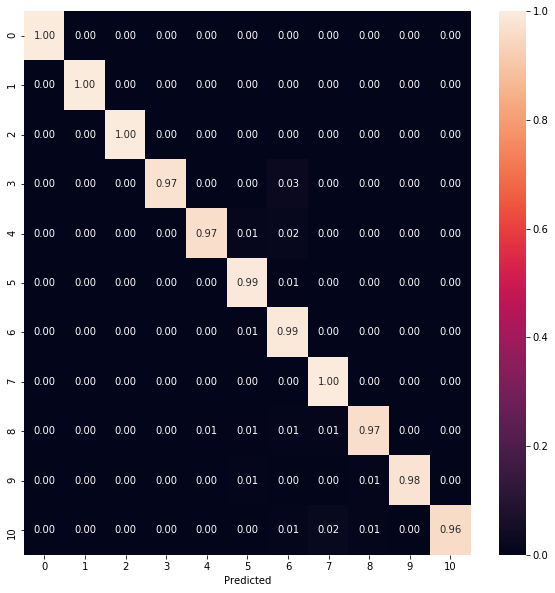

In [170]:
# Calcular ajuste de modelo en train
y_predT = rfc.predict(X_train)

evaluate_model(y_train, y_predT)
matconfision(y_train, y_predT)

El f1 score es de:  0.3841190700912416
El acc score es de:  0.39949748743718594
La precision es de:  0.39949748743718594
El f1 score es de:  0.39949748743718594


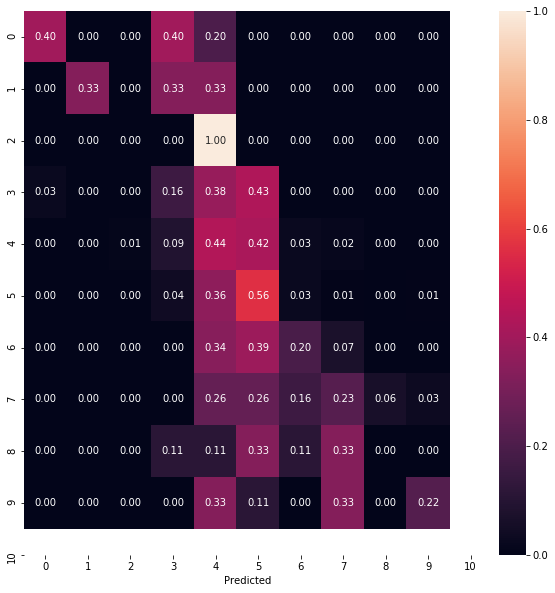

In [171]:
# Validar modelo test
y_pred = rfc.predict(X_test)

evaluate_model(y_test, y_pred)
matconfision(y_test, y_pred)

In [172]:
# Plot the feature importances
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(15)

,importance
Tristeza,0.073571
Edad,0.071371
Ingreso_Hogares,0.068990
Preocupacion,0.067090
Satisfaccion_trabajo,0.053737
Satisfaccion_vida,0.050553
Escalon_vida,0.048522
Satisfaccion_economica,0.047856
Satisfaccion_salud,0.047554
Satisfaccion_seguridad,0.046472


In [174]:
data = pd.read_csv('data_general2.csv', sep = ',', header = 0)
data = data.loc[:, ['Ingreso_Hogares', 'Edad', 'Felicidad']]
data.shape

(3973, 3)

In [175]:
# Extraer la variable dependiente
y = data['Felicidad']

In [176]:
X = data.drop(['Felicidad'], axis = 1)

In [177]:
# dividir la data en X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 123)

In [178]:
rfc = RandomForestClassifier(random_state = 123)
rfc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

El f1 score es de:  0.9196610674048007
El acc score es de:  0.9199788023317436
La precision es de:  0.9199788023317436
El f1 score es de:  0.9199788023317436


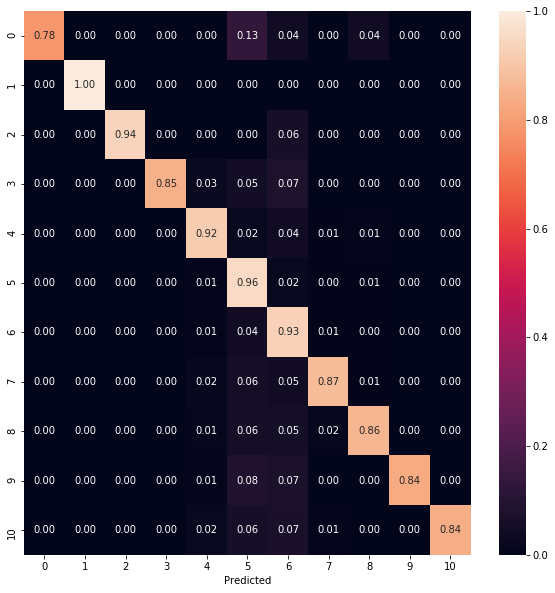

In [179]:
# Calcular ajuste de modelo en train
y_predT = rfc.predict(X_train)

evaluate_model(y_train, y_predT)
matconfision(y_train, y_predT)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



El f1 score es de:  0.2665312140029477
El acc score es de:  0.27638190954773867
La precision es de:  0.27638190954773867
El f1 score es de:  0.27638190954773867


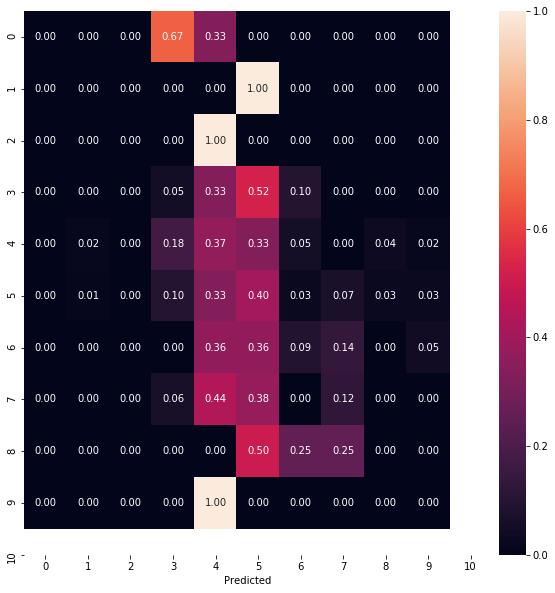

In [180]:
# Validar modelo test
y_pred = rfc.predict(X_test)

evaluate_model(y_test, y_pred)
matconfision(y_test, y_pred)

In [144]:
# Plot the feature importances
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(15)

,importance
Ingreso_Hogares,0.810947
Edad,0.189053


# <center> Para cerchas

In [41]:
df3 = pd.read_csv('Caracteristicas y composicion del hogar.csv', sep = ';', header = 0)

In [42]:
df3 = df3.rename(columns={'P1894':'ID', 'P6020':'Sexo', 'P6051':'Parentesco', 'P6040':'Edad', 'P5502':'Estado_civil',
                          'P6096': 'Razon_desplazamiento', 'P6081': 'Padre_vive', 'P6083': 'Madre_vive', 
                          'P1895': 'Satisfaccion_vida', 'P1896': 'Satisfaccion_economica', 'P1897': 'Satisfaccion_salud', 
                          'P1898': 'Satisfaccion_seguridad', 'P1899': 'Satisfaccion_trabajo', 'P1901': 'Felicidad',
                          'P1903': 'Preocupacion', 'P1904': 'Tristeza', 'P1905': 'Deseo_vivir', 'P1927': 'Escalon_vida',
                          'P6081S1': 'Posicion_Padre', 'P6083S1': 'Posicion_Madre'})

In [43]:
df3.drop(['FEX_C', 'P6034', 'P6071S1', 'P756', 'P756S2', 'P767', 'P6076', 'P6076S1', 'P6076S2', 'P6077', 
          'P6087', 'P6088', 'P6080', 'P5667', 'P6016', 'P756S1', 'P6071', 'P6074'], axis=1, inplace=True)

In [44]:
df3.loc[:,['DIRECTORIO', 'Parentesco', 'Sexo', 'Edad']].head()

,DIRECTORIO,Parentesco,Sexo,Edad
0,7000000,1,2,64
1,7000000,3,1,26
2,7000001,1,1,56
3,7000001,2,2,54
4,7000001,3,2,14


In [45]:
# sacar los directorios que me interesan
df2 = pd.read_csv('data_general.csv', sep = ',', header = 0)
df2 = df2.loc[:, 'DIRECTORIO']
df2.head()

0    7000000
1    7000003
2    7000011
3    7000017
4    7000024
Name: DIRECTORIO, dtype: int64

In [46]:
# unir tablas para sacar solo los datos que me interesan
tabla2 = pd.merge(df3, df2, on = ['DIRECTORIO'])
tabla2 = tabla2.loc[:, ['DIRECTORIO', 'Sexo', 'Edad', 'Parentesco']]
tabla2.head()

,DIRECTORIO,Sexo,Edad,Parentesco
0,7000000,2,64,1
1,7000000,1,26,3
2,7000003,2,61,1
3,7000003,2,28,3
4,7000011,2,27,1


### Crear columna de 1 (unos para las madres) y eliminacion de parentesco igual a 1

In [47]:
# adicionar una lista como una columna
listOfnumbers = [1] * len(tabla2)
tabla2['Madre'] = listOfnumbers
# eliminar una caracteristica de una variable
#tabla2.drop(tabla2[tabla2['Parentesco'] == 1].index, inplace = True)
# re ordenar las columnas
tabla2 = tabla2.loc[:, ['DIRECTORIO', 'Madre', 'Parentesco', 'Sexo', 'Edad']]
tabla2.head(20)

,DIRECTORIO,Madre,Parentesco,Sexo,Edad
0,7000000,1,1,2,64
1,7000000,1,3,1,26
2,7000003,1,1,2,61
3,7000003,1,3,2,28
4,7000011,1,1,2,27
5,7000011,1,3,1,9
6,7000011,1,3,1,5
7,7000017,1,1,2,74
8,7000017,1,4,1,23
9,7000024,1,1,2,78


In [48]:
# Guardar tabla 
tabla2.to_csv('tabla2.csv', index = False, encoding = "UTF-8")

In [183]:
tabla2 = pd.read_csv('tabla2.csv', sep = ',', header = 0)
# Selecciono la primera familia 
datauax = tabla2[tabla2['DIRECTORIO'] == 7000722]
datauax

,DIRECTORIO,Madre,Parentesco,Sexo,Edad
538,7000722,1,1,2,41
539,7000722,1,3,1,13
540,7000722,1,3,2,18
541,7000722,1,4,1,0
542,7000722,1,7,2,38
543,7000722,1,9,2,16
544,7000722,1,9,1,13
545,7000722,1,9,2,7


In [56]:
lista_from = []
lista_to = []
contador_h = 1
contador_n = 1
contador_hermanos = 1

# Iteración por filas del DataFrame:
for index, row in datauax.iterrows():
    
    if(row['Parentesco'] == 1):
        edad_madre = row['Edad']
    
    if(row['Parentesco'] == 3):
        if(row['Sexo'] == 1):
            lista_from.append(1)
            palabrah = 'Hijo_'+ str(contador_h)
            lista_to.append(palabrah)
            contador_h += 1
        else:
            lista_from.append(1)
            palabrah = 'Hija_'+ str(contador_h)
            lista_to.append(palabrah)
            contador_h += 1
            
    elif(row['Parentesco'] == 4):
        if(row['Sexo'] == 1):
            lista_from.append(palabrah)
            palabran = 'Nieto_'+ str(contador_n)
            lista_to.append(palabran)
            contador_n += 1
        else:
            lista_from.append(palabrah)
            palabra = 'Nieta_'+ str(contador_n)
            lista_to.append(palabran)
            contador_n += 1
        
    elif(row['Parentesco'] == 5):
        if(row['Sexo'] == 1):
            lista_from.append(1)
            palabra = 'Padre*'
            lista_to.append(palabra)
        else:
            lista_from.append(1)
            palabra = 'Madre*'
            lista_to.append(palabra)
    
    
    elif(row['Parentesco'] == 6):
        if(row['Sexo'] == 1):
            lista_from.append(1)
            palabra = 'Suegro'
            lista_to.append(palabra)
        else:
            lista_from.append(1)
            palabra = 'Suegra'
            lista_to.append(palabra)
    
    
    elif(row['Parentesco'] == 7):
        if(row['Sexo'] == 1):
            if(row['Edad'] >=  edad_madre):
                lista_from.append(1)
                palabrabro = 'Hermano_mayor_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
            else:
                lista_from.append(1)
                palabrabro = 'Hermano_menor_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
        else:
            if(row['Edad'] >=  edad_madre):
                lista_from.append(1)
                palabrabro = 'Hermana_mayor_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
            else:
                lista_from.append(1)
                palapalabrabrobra = 'Hermana_menor_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
    
    
    elif(row['Parentesco'] == 8):
        if(row['Sexo'] == 1):
            lista_from.append(palabrah)
            palabra8 = 'Yerno*'
            lista_to.append(palabra8)
        else:
            lista_from.append(palabrah)
            palabra8 = 'Nuera*'
            lista_to.append(palabra8)    
    
    
    
    else:
        lista_from.append(row['Madre'])
        lista_to.append(row['Parentesco'])
        
datauax['from'] = lista_from
datauax['to'] = lista_to
#datauax.drop(['I_HOGAR'], axis=1, inplace=True)
datauax        


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,DIRECTORIO,Madre,Parentesco,Sexo,Edad,from,to
2592,7003531,1,1,2,44,1,1
2593,7003531,1,3,2,17,1,Hija_1
2594,7003531,1,8,1,26,Hija_1,Yerno*
2595,7003531,1,4,1,2,Hija_1,Nieto_1
2596,7003531,1,7,1,41,1,Hermano1


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



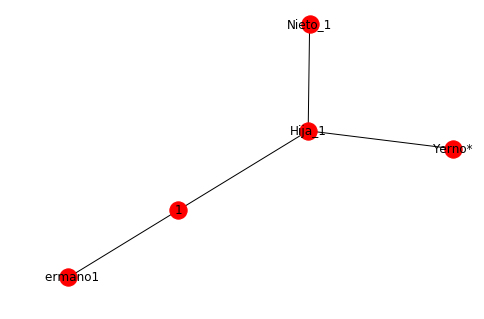

In [57]:
# Build your graph
G = nx.from_pandas_edgelist(datauax, 'from', 'to')
 
# Plot it
nx.draw(G, with_labels = True)
plt.show()

In [184]:
def familia(datauax):
    lista_from = []
    lista_to = []
    contador_h = 1
    contador_n = 1
    contador_hermanos = 1
    
    datauax.drop(datauax[datauax['Parentesco'] > 8].index, inplace = True)

    # Iteración por filas del DataFrame:
    for index, row in datauax.iterrows():

        if(row['Parentesco'] == 1):
            edad_madre = row['Edad']

        if(row['Parentesco'] == 3):
            if(row['Sexo'] == 1):
                lista_from.append(1)
                palabrah = 'Hijo_'+ str(contador_h)
                lista_to.append(palabrah)
                contador_h += 1
            else:
                lista_from.append(1)
                palabrah = 'Hija_'+ str(contador_h)
                lista_to.append(palabrah)
                contador_h += 1

        elif(row['Parentesco'] == 4):
            if(row['Sexo'] == 1):
                lista_from.append(palabrah)
                palabran = 'Nieto_'+ str(contador_n)
                lista_to.append(palabran)
                contador_n += 1
            else:
                lista_from.append(palabrah)
                palabra = 'Nieta_'+ str(contador_n)
                lista_to.append(palabran)
                contador_n += 1

        elif(row['Parentesco'] == 5):
            if(row['Sexo'] == 1):
                lista_from.append(1)
                palabra = 'Padre*'
                lista_to.append(palabra)
            else:
                lista_from.append(1)
                palabra = 'Madre*'
                lista_to.append(palabra)


        elif(row['Parentesco'] == 6):
            if(row['Sexo'] == 1):
                lista_from.append(1)
                palabra = 'Suegro'
                lista_to.append(palabra)
            else:
                lista_from.append(1)
                palabra = 'Suegra'
                lista_to.append(palabra)


        elif(row['Parentesco'] == 7):
            if(row['Sexo'] == 1):
                lista_from.append(1)
                palabrabro = 'Hermano_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
                
            else:
                lista_from.append(1)
                palabrabro = 'Hermana_'+ str(contador_hermanos)
                lista_to.append(palabrabro)
                contador_hermanos += 1
        
        elif(row['Parentesco'] == 8):
            if(row['Sexo'] == 1):
                lista_from.append(palabrah)
                palabra8 = 'Yerno*'
                lista_to.append(palabra8)
            else:
                lista_from.append(palabrah)
                palabra8 = 'Nuera*'
                lista_to.append(palabra8)    



        else:
            lista_from.append(row['Madre'])
            lista_to.append(row['Parentesco'])

    datauax.loc[:,'from'] = lista_from
    datauax.loc[:,'to'] = lista_to
    datauax.drop(['Madre'], axis=1, inplace=True)
    datauax.drop(datauax[datauax['to'] == 1].index, inplace = True)
    datauax.loc[:,'from'] = np.where((datauax['from'] == 1), 'Madre', datauax.loc[:,'from'])
    return datauax 

In [185]:
tt = familia(datauax)
tt

,DIRECTORIO,Parentesco,Sexo,Edad,from,to
539,7000722,3,1,13,Madre,Hijo_1
540,7000722,3,2,18,Madre,Hija_2
541,7000722,4,1,0,Hija_2,Nieto_1
542,7000722,7,2,38,Madre,Hermana_1


In [278]:
def colores(X):
    lista1 = list(X)
    lista2 = [10]
    for i in lista1:
        res = 0
        if(i == 3):
            res = 9
        elif(i == 4):
            res = 4
        elif(i == 5):
            res = 5
        elif(i == 6):
            res = 6
        elif(i == 7):
            res = 8
        lista2.append(res)
    return lista2

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



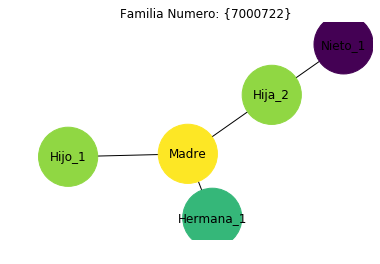

In [279]:
G = nx.from_pandas_edgelist(tt, 'from', 'to', create_using = nx.Graph())

family = set([e for e in tt['DIRECTORIO']])
# Custom the nodes:
plt.title('Familia Numero: {}'.format(family))
nx.draw(G, with_labels = True, node_color = colores(tt['Parentesco']), 
        node_size = 3500, edge_color = 'black', 
        width = 1.0, edge_cmap = plt.cm.Pastel2)